# Prédiction de la consommation totale d’énergie

### Variable à prédire :'SiteEnergyUseWN(kBtu)'

**Definition** : The annual amount of energy consumed by the property from all sources of energy.


- 'SiteEUIWN(kBtu/sf)' 
consommation normalisée au pied carré (sf : square feet), donc ramenée à la surface du bâtiment, correspond à une intensité de consommation

**Definition** : Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.

In [1]:
#on importe les bibliothèques dont on va se servir
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score,mean_squared_log_error
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#Fonctions dont on va se servir

'''Fonction qui retourne un tableau contenant le nom de la variable, le nombre de valeur manquante ainsi que le 
pourcentage de valeurs manquantes associé '''

def missingValues(df):
    df_null = pd.DataFrame({'Count' : df.isnull().sum(), 'Percentage': round(100*df.isnull().sum()/len(df),2)})
    df_null_pos = df_null[df_null['Count'] > 0 ]
    df_null_sorted = df_null_pos.sort_values(by=['Percentage'], ascending = False)
    df_null_sorted = pd.DataFrame(df_null_sorted)
    df_null_sorted.reset_index(inplace = True)
    df_null_sorted.rename(columns={'index':'Variable Name'}, inplace=True)
    return df_null_sorted

'''Cette fonction permet de supprimer les variables avec un pourcentage de valeur manquante supérieur à la limite'''
def dropColumns(df, limit):
    tab = missingValues(df)
    columns_to_keep = list()

    for row in tab.iterrows():        
        if float(row[1]['Percentage']) < float(limit):
            columns_to_keep.append(row[1]['Variable Name'])
            
    data = df[columns_to_keep]
    return data

def add_results(regressor, nom_modèle, cas, results):
    results = results.append(pd.DataFrame({'Modèle' : [nom_modèle],
                                       'Cas': cas,
                                       'Score_RMSE_test' : [np.sqrt(mean_squared_error(regressor.predict(X_test_std), y_test))],
                                       'Score_RMSE_train' : [np.sqrt(mean_squared_error(regressor.predict(X_train_std), y_train))],
                                     'Score_r2_test': [regressor.score(X_test_std,y_test)],
                                      'Score_r2_train': [regressor.score(X_train_std,y_train)],
                                      }),ignore_index=True)
    return results 

#### On importe le dataframe nettoyé

In [3]:
df = pd.read_csv('df.csv', index_col = 0)
df.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,PropertyUse_ratio_Education,PropertyUse_ratio_Factory,PropertyUse_ratio_Government services,PropertyUse_ratio_Health,PropertyUse_ratio_Hotel/Senior Care/Housing,PropertyUse_ratio_Leisure,PropertyUse_ratio_No Use,PropertyUse_ratio_Office,PropertyUse_ratio_Other,PropertyUse_ratio_Parking,PropertyUse_ratio_Retail,PropertyUse_ratio_Swimming Pool,PropertyUse_ratio_Technology/Science,Electricity_ratio,Steam_ratio,NaturalGas_ratio,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,NumberofBuildings_log,NumberofFloors_log,PropertyGFATotal_log,PropertyGFAParking_log,PropertyGFABuilding(s)_log,SiteEnergyUseWN(kBtu)_log,TotalGHGEmissions_log
0,47.61220,-122.33799,1927,1.0,12,88434,0,88434,60.0,7456910.0,249.98,0.0,0.0,0.0,0.0,100.000000,0.000000,0,0.0,0.0,0.000000,0.0,0,0.0,0.546060,0.277302,0.176638,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.564949,11.390023,0.000000,11.390023,15.824652,5.525373
1,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,61.0,8664479.0,295.86,0.0,0.0,0.0,0.0,80.991831,4.462855,0,0.0,0.0,14.545314,0.0,0,0.0,0.386609,0.000000,0.613391,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.484907,11.547974,9.620129,11.390792,15.974742,5.693261
2,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,43.0,73937112.0,2089.28,0.0,0.0,0.0,0.0,100.000000,0.000000,0,0.0,0.0,0.000000,0.0,0,0.0,0.682307,0.297113,0.020579,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,3.737670,13.770629,12.189532,13.540275,18.118725,7.645053
3,47.61412,-122.33664,1926,1.0,10,61320,0,61320,56.0,6946800.5,286.43,0.0,0.0,0.0,0.0,100.000000,0.000000,0,0.0,0.0,0.000000,0.0,0,0.0,0.407519,0.325913,0.266567,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.397895,11.023878,0.000000,11.023878,15.753792,5.660979
4,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,75.0,14656503.0,505.01,0.0,0.0,0.0,0.0,64.477629,0.000000,0,0.0,0.0,35.522371,0.0,0,0.0,0.378802,0.000000,0.621198,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,2.944439,12.075856,11.034906,11.640272,16.500395,6.226556


#### On sépare les différents types de colonnes

In [4]:
df_columns = pd.DataFrame({'feature': df.columns})

columns_PrimaryPropertyType = df_columns.loc[df_columns['feature'].str.startswith('PrimaryPropertyType_')]['feature'].tolist()
columns_Neighborhood = df_columns.loc[df_columns['feature'].str.startswith('Neighborhood_')]['feature'].tolist()
columns_PropertyUse_ratio = df_columns.loc[df_columns['feature'].str.startswith('PropertyUse_ratio_')]['feature'].tolist()
columns_BuildingType = df_columns.loc[df_columns['feature'].str.startswith('BuildingType_')]['feature'].tolist()


#### On crée un dataframe où on enregistrera les scores de chaque algorithme utilisé 

In [5]:
results = pd.DataFrame({})

## Premières prédictions : 

#### On selectionne le dataframe pour les premières prédictions :
On commence directement avec des variables et les algorithmes qui ont engendré un bon score pour les émissions du batiment 

In [6]:
df_1er_essai = df.drop(['TotalGHGEmissions',
                        'SiteEnergyUseWN(kBtu)_log',
                        'TotalGHGEmissions_log',
                        'ENERGYSTARScore',
                        'Electricity_ratio',
                        'Steam_ratio',
                        'NaturalGas_ratio',
                        'NumberofBuildings',
                        'NumberofBuildings_log',
                         'NumberofFloors',
                        'NumberofFloors_log',
                        'PropertyGFATotal_log',
                        'PropertyGFAParking',
                        'PropertyGFAParking_log',
                        'PropertyGFABuilding(s)_log'
                       ] 
                       + columns_PropertyUse_ratio 
                       #+ columns_BuildingType
                       , axis=1)

In [7]:
df_1er_essai.columns

Index(['Latitude', 'Longitude', 'YearBuilt', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'SiteEnergyUseWN(kBtu)',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS', 'BuildingType_Nonresidential WA',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
  

#### Nous allons séparer les données en un ensemble de données X et une variable cible y que nous voulons prédire.

In [8]:
X = df_1er_essai.drop(['SiteEnergyUseWN(kBtu)'], axis=1)
y = df_1er_essai['SiteEnergyUseWN(kBtu)']

#### On separe les données d'entrainement et de test

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#### On standardise donc les données des variables numériques

In [10]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)

X_train_std = pd.DataFrame(data=standardScaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=standardScaler.transform(X_test),index=X_test.index,columns=X_test.columns)

## Dummy regressor 

In [11]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_std, y_train)

DummyRegressor()

In [12]:
# Score R2
print('score train :', dummy.score(X_train_std, y_train))
print('score test :', dummy.score(X_test_std, y_test))

#Score RMSE
print('rmse train :', np.sqrt(mean_squared_error(dummy.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(dummy.predict(X_test_std), y_test)))

score train : 0.0
score test : -0.0073166769232853035
rmse train : 17248316.235856816
rmse test : 11117799.189000338


In [13]:
# On ajoute les scores au dataframe results
results = add_results(dummy,'Dummy Regressor', 'Premières prédictions', results)

## Regression Regularisée : Ridge

#### l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard 
on cherche le coefficient de regularisation alpha adapté

In [14]:
#On va tester un certain nombre de coefficients pour trouver celui qui est optimal
alphas = (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 20, 30, 50, 100, 200, 300, 350, 400)
ridge_reg = RidgeCV(alphas = alphas, scoring ='r2')
ridge_reg.fit(X_train_std, y_train)


RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 3.0e-01, 7.0e-01, 1.0e+00, 1.0e+01,
       2.0e+01, 3.0e+01, 5.0e+01, 1.0e+02, 2.0e+02, 3.0e+02, 3.5e+02,
       4.0e+02]),
        scoring='r2')

In [15]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

# Score R2
print('score train :', ridge_reg.score(X_train_std, y_train))
print('score test :', ridge_reg.score(X_test_std, y_test))

#Score RMSE
print('rmse train :', np.sqrt(mean_squared_error(ridge_reg.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(ridge_reg.predict(X_test_std), y_test)))


alpha sélectionné par c-v : 400.0
score train : 0.3596874060515979
score test : 0.36764809360394957
rmse train : 13802022.401853867
rmse test : 8808769.16812742


In [16]:
# On ajoute les scores au dataframe results
results = add_results(ridge_reg, 'RidgeCV', 'Premières prédictions', results)

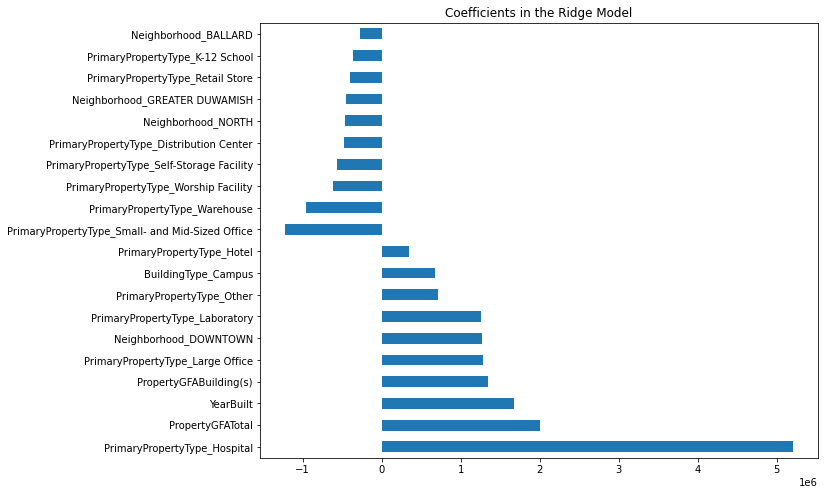

In [17]:
# on affiche les variables les plus importantes du modèle, relativement aux coefficients calculés
coef = pd.Series(ridge_reg.coef_, index = X_train.columns)

imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values().head(10)])

plt.figure(figsize= (10,8))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model");

## Random Forest Regressor

In [18]:
#on va tester un certain nombre de paramètres pour trouver celui qui est optimal

parameters = {'n_estimators' : [5,10,20,25,30,50,90,100,110,120,130,200], #nombre d'arbres de décision
              'min_samples_leaf' : [1,2,3,4,5,10],                        #nombre de feuilles minimales dans un noeud
              'max_features': ['auto', 'sqrt']                            #nombre de features observées pour chaque arbre
}

In [19]:
# Créer un regresseur Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
rfr_search = model_selection.GridSearchCV(RandomForestRegressor(n_jobs=-1,random_state=123),
                                          param_grid = parameters,
                                          scoring='r2',
                                          cv=5,
                                          n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
rfr = rfr_search.fit(X_train_std, y_train)

In [20]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le RFR sont :{}".format(rfr.best_params_))

# Scores R2
print('score train :', rfr.score(X_train_std, y_train))
print('score test :', rfr.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(rfr.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(rfr.predict(X_test_std), y_test)))

#Score RMSLE 
print('rmsle train :', np.sqrt(mean_squared_log_error(rfr.predict(X_train_std), y_train)))
print('rmsle test :', np.sqrt(mean_squared_log_error(rfr.predict(X_test_std), y_test)))


les meilleurs hyperparamètres pour le RFR sont :{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}
score train : 0.6742539235370276
score test : 0.5751020752479014
rmse train : 9844333.154464476
rmse test : 7220680.327494724
rmsle train : 1.6077925024560966
rmsle test : 1.166712530711869


In [21]:
# On ajoute les scores au dataframe results
results = add_results(rfr, 'RFR', 'Premières prédictions', results)

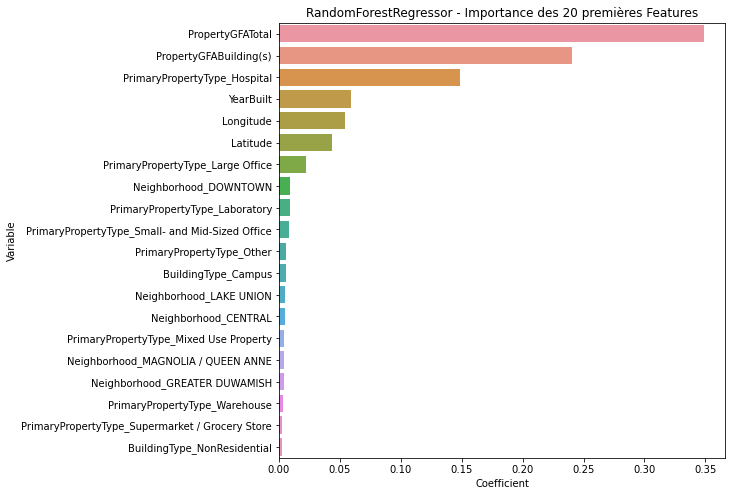

In [22]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(rfr.best_estimator_.feature_importances_)
liste_coefs_rfr = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rfr['Variable'].head(20),
            x = liste_coefs_rfr['Coefficient'].head(20))
plt.show()

### Gradient Boosting Regressor 

In [23]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [24]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 0.8}
score train : 0.7357718170761257
score test : 0.5489738974961498
rmse train : 8866174.510546114
rmse test : 7439378.441358701


In [25]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'Premières prédictions', results)

## Resultat du premier essai

In [26]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,1.111780e+07,1.724832e+07,-0.007317,0.000000
1,RidgeCV,Premières prédictions,8.808769e+06,1.380202e+07,0.367648,0.359687
2,RFR,Premières prédictions,7.220680e+06,9.844333e+06,0.575102,0.674254
3,Gradient Boosting,Premières prédictions,7.439378e+06,8.866175e+06,0.548974,0.735772


# Deuxième essai de predictions : passage au log de la variable cible

In [27]:
df_2eme_essai = df.drop(['TotalGHGEmissions',
                         'ENERGYSTARScore',
                         #'PropertyGFABuilding(s)',
                         'NumberofBuildings',
                         'NumberofFloors',
                         'Electricity_ratio',
                         'Steam_ratio', 
                         'NaturalGas_ratio',
                         'NumberofBuildings_log',
                         'NumberofFloors_log',
                         'PropertyGFATotal_log',
                         #'PropertyGFATotal',
                         'PropertyGFAParking',
                         'PropertyGFAParking_log',
                         'PropertyGFABuilding(s)_log',
                         'SiteEnergyUseWN(kBtu)',
                         #'SiteEnergyUseWN(kBtu)_log',
                         'TotalGHGEmissions_log'] 
                        #+ columns_PrimaryPropertyType
                        + columns_PropertyUse_ratio 
                        , axis=1)

In [28]:
df_2eme_essai.columns

Index(['Latitude', 'Longitude', 'YearBuilt', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'BuildingType_Campus',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'BuildingType_Nonresidential WA', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Superm

### On sépare la variable cible et les features 

In [29]:
X2 = df_2eme_essai.drop(['SiteEnergyUseWN(kBtu)_log'], axis=1)
y2 = df_2eme_essai['SiteEnergyUseWN(kBtu)_log']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [30]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X2, y2, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
standardScaler = StandardScaler()
standardScaler.fit(X_train)

X_train_std = pd.DataFrame(data=standardScaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=standardScaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Regression Regularisée : Ridge

In [31]:
#l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard 
# on cherche le coefficient de regularisation alpha adapté
#on va tester un certain nombre de coefficients pour trouver celui qui est optimal

ridge_reg = RidgeCV(alphas = (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 20, 30, 50, 100, 200, 300, 350, 400))
ridge_reg.fit(X_train_std, y_train)

RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 3.0e-01, 7.0e-01, 1.0e+00, 1.0e+01,
       2.0e+01, 3.0e+01, 5.0e+01, 1.0e+02, 2.0e+02, 3.0e+02, 3.5e+02,
       4.0e+02]))

In [32]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

alpha sélectionné par c-v : 400.0


In [33]:
# On ajoute les scores au dataframe results
results = add_results(ridge_reg, 'RidgeCV', 'Passage au log de la variable cible', results)


## Random Forest Regressor

In [34]:
#on va tester un certain nombre de paramètres pour trouver celui qui est optimal

parameters = {'n_estimators' : [5,10,20,25,30,50,90,100,110,120,130,200], #nombre d'arbres de décision
              'min_samples_leaf' : [1,2,3,4,5,10],                        #nombre de feuilles minimales dans un noeud
              'max_features': ['auto', 'sqrt']                            #nombre de features observées pour chaque arbre
}
# Créer un regresseur Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
rfr_search = model_selection.GridSearchCV(RandomForestRegressor(n_jobs=-1,random_state=123),
                                          param_grid = parameters,
                                          scoring='r2',
                                          cv=5,
                                          n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
rfr_search.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [5, 10, 20, 25, 30, 50, 90, 100, 110,
                                          120, 130, 200]},
             scoring='r2')

In [35]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le RFR sont :{}".format(rfr_search.best_params_))

les meilleurs hyperparamètres pour le RFR sont :{'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 30}


In [36]:
# On ajoute les scores au dataframe results
results = add_results(rfr_search, 'RFR', 'Passage au log de la variable cible', results)


### Gradient Boosting Regressor 

In [37]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [38]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le GBR sont :{}".format(gbr_grid.best_params_))


les meilleurs hyperparamètres pour le GBR sont :{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 100, 'subsample': 0.6}


In [39]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'Passage au log de la variable cible', results)

### Résultat du 2ème essai

In [40]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,1.111780e+07,1.724832e+07,-0.007317,0.000000
1,RidgeCV,Premières prédictions,8.808769e+06,1.380202e+07,0.367648,0.359687
2,RFR,Premières prédictions,7.220680e+06,9.844333e+06,0.575102,0.674254
3,Gradient Boosting,Premières prédictions,7.439378e+06,8.866175e+06,0.548974,0.735772
4,RidgeCV,Passage au log de la variable cible,1.251702e+00,1.628812e+00,0.234730,0.242211
5,RFR,Passage au log de la variable cible,1.072386e+00,1.450636e+00,0.438286,0.398932
6,Gradient Boosting,Passage au log de la variable cible,1.069047e+00,1.409123e+00,0.441779,0.432842


### Le passage au log de la variable cible réduit l'erreur RMSE (c'est normal car la RMSE s’exprime dans la même unité que la variable à prédire ) et réduit le R2 
on décide de ne pas passer au log pour la variable cible

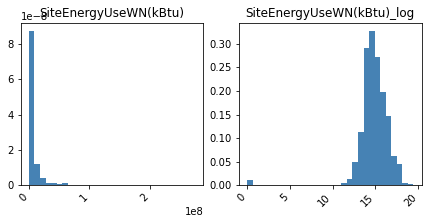

In [41]:
#On affiche un histogramme pour regarder la distribution de la variable cible
col_histo = ['SiteEnergyUseWN(kBtu)','SiteEnergyUseWN(kBtu)_log']
df_histo = df.loc[:,col_histo]
values_histo = df_histo.values

fig = plt.figure(constrained_layout=True,figsize=(16, 12))

for feat_idx in range(values_histo.shape[1]):
    ax = fig.add_subplot(5,6, (feat_idx+1))
    h = ax.hist(values_histo[:, feat_idx], 
                bins=30,
                color='steelblue',
                density=True,
                edgecolor='none')
    
    ax.set_title(df_histo.columns[feat_idx], fontsize=12)
    plt.xticks(rotation=45, ha='right')

# Troisième essai de predictions : passage au log des features asymétriques

In [42]:
#on supprime l'autre variable de prediction qu'on va predire dans l'autre notebook
# et les variables qui nous semble pas pertinentes

df_3eme_essai = df.drop(['TotalGHGEmissions',
                         'TotalGHGEmissions_log',
                         'ENERGYSTARScore',
                         'Electricity_ratio',
                         'Steam_ratio', 
                         'NaturalGas_ratio',
                         'NumberofBuildings',
                         'NumberofFloors',
                         'NumberofBuildings_log',
                         'NumberofFloors_log',
                         #'PropertyGFATotal_log',
                         'PropertyGFATotal',
                         'PropertyGFAParking',
                         'PropertyGFAParking_log',
                          'PropertyGFABuilding(s)',
                         #'PropertyGFABuilding(s)_log',
                         'SiteEnergyUseWN(kBtu)_log',
                        ] 
                        #+ columns_PrimaryPropertyType
                        + columns_PropertyUse_ratio 
                        , axis=1)

In [43]:
df_3eme_essai.columns

Index(['Latitude', 'Longitude', 'YearBuilt', 'SiteEnergyUseWN(kBtu)',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS', 'BuildingType_Nonresidential WA',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store

### On sépare la variable cible et les features 

In [44]:
X3 = df_3eme_essai.drop(['SiteEnergyUseWN(kBtu)'], axis=1)
y3 = df_3eme_essai['SiteEnergyUseWN(kBtu)']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [45]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X3, y3, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
standardScaler = StandardScaler()
standardScaler.fit(X_train)

X_train_std = pd.DataFrame(data=standardScaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=standardScaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Regression Regularisée : Ridge

In [46]:
#l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard 
# on cherche le coefficient de regularisation alpha adapté
#on va tester un certain nombre de coefficients pour trouver celui qui est optimal
alpha_ridge = (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 20, 30, 50,120, 130,140,150,200, 300, 350, 400)

ridge_reg = RidgeCV(alphas = alpha_ridge, 
                   scoring = 'r2')

ridge_reg.fit(X_train_std, y_train)

RidgeCV(alphas=array([1.0e-03, 1.0e-02, 1.0e-01, 3.0e-01, 7.0e-01, 1.0e+00, 1.0e+01,
       2.0e+01, 3.0e+01, 5.0e+01, 1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02,
       2.0e+02, 3.0e+02, 3.5e+02, 4.0e+02]),
        scoring='r2')

In [47]:
#Alpha choisi par Cross Validation
print('alpha sélectionné par c-v :', ridge_reg.alpha_)

# Score R2
print('score train :', ridge_reg.score(X_train_std, y_train))
print('score test :', ridge_reg.score(X_test_std, y_test))

#Score RMSE
print('rmse train :', np.sqrt(mean_squared_error(ridge_reg.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(ridge_reg.predict(X_test_std), y_test)))

alpha sélectionné par c-v : 200.0
score train : 0.4850781889017354
score test : 0.5410561141957064
rmse train : 12377055.834782802
rmse test : 7504393.656308594


In [48]:
# On ajoute les scores au dataframe results
results = add_results(ridge_reg, 'RidgeCV',  "passage au log des features asymétriques", results)

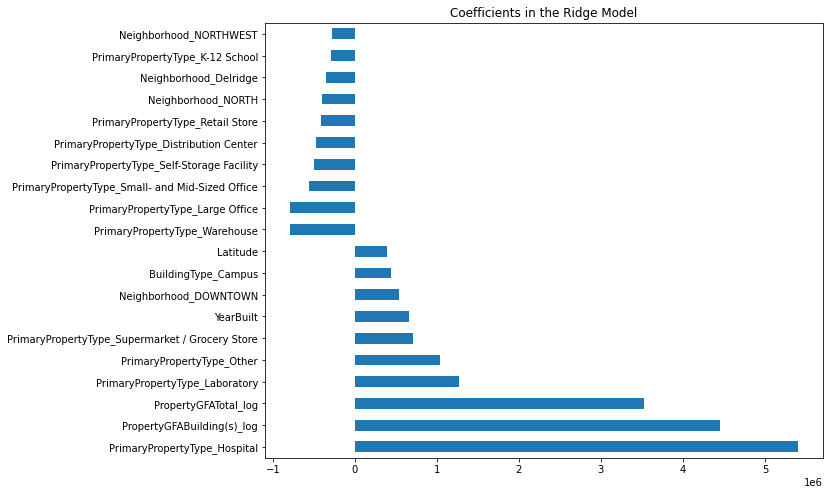

In [49]:
# on affiche les variables les plus importantes du modèle, relativement aux coefficients calculés
coef = pd.Series(ridge_reg.coef_, index = X_train.columns)

imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values().head(10)])

plt.figure(figsize= (10,8))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model");

### Random Forest Regressor 

In [50]:
#on va tester un certain nombre de paramètres pour trouver celui qui est optimal

parameters = {'n_estimators' : [5,10,20,25,30,50,90,100,200], #nombre d'arbres de décision
              'min_samples_leaf' : [1,2,3,4,5,10],            #nombre de feuilles minimales dans un noeud
              'max_features': ['auto', 'sqrt']                #nombre de features observées pour chaque arbre
}

In [51]:
# Créer un regresseur Random Forest Regressor avec recherche d'hyperparamètre par validation croisée
rfr_search = model_selection.GridSearchCV(RandomForestRegressor(n_jobs=-1,random_state=123),
                                          param_grid = parameters,
                                          scoring='r2',
                                          cv=5,
                                          n_jobs=-1)

# Optimiser ce regresseur sur le jeu d'entraînement
rfr_search.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [5, 10, 20, 25, 30, 50, 90, 100, 200]},
             scoring='r2')

In [52]:
#Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le RFR sont :{}".format(rfr_search.best_params_))

# Scores R2
print('score train :', rfr_search.score(X_train_std, y_train))
print('score test :', rfr_search.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(rfr_search.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(rfr_search.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le RFR sont :{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 10}
score train : 0.5957074731459803
score test : 0.5511566912383368
rmse train : 10967169.683684161
rmse test : 7421354.735534074


In [53]:
# On ajoute les scores au dataframe results
results = add_results(rfr_search, 'RFR', "passage au log des features asymétriques", results)

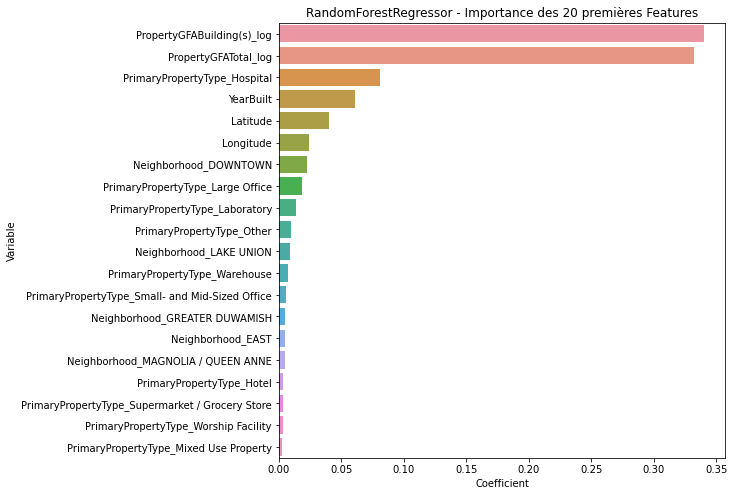

In [54]:
#On affiche les variables les plus importantes dans le modele 
coefficients = abs(rfr_search.best_estimator_.feature_importances_)
liste_coefs_rfr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rfr['Variable'].head(20),
            x = liste_coefs_rfr['Coefficient'].head(20))
plt.show()

### Gradient Boosting Regressor

In [55]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [56]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le GBR sont :{}".format(gbr_grid.best_params_))


les meilleurs hyperparamètres pour le GBR sont :{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 0.8}


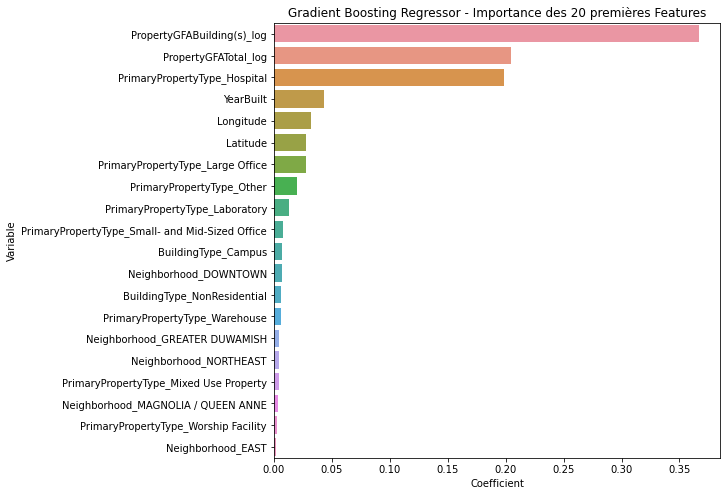

In [57]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

In [58]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', "passage au log des features asymétriques", results)

### Résultats du 3eme essai

In [59]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,1.111780e+07,1.724832e+07,-0.007317,0.000000
1,RidgeCV,Premières prédictions,8.808769e+06,1.380202e+07,0.367648,0.359687
2,RFR,Premières prédictions,7.220680e+06,9.844333e+06,0.575102,0.674254
3,Gradient Boosting,Premières prédictions,7.439378e+06,8.866175e+06,0.548974,0.735772
4,RidgeCV,Passage au log de la variable cible,1.251702e+00,1.628812e+00,0.234730,0.242211
5,RFR,Passage au log de la variable cible,1.072386e+00,1.450636e+00,0.438286,0.398932
6,Gradient Boosting,Passage au log de la variable cible,1.069047e+00,1.409123e+00,0.441779,0.432842
7,RidgeCV,passage au log des features asymétriques,7.504394e+06,1.237706e+07,0.541056,0.485078
8,RFR,passage au log des features asymétriques,7.421355e+06,1.096717e+07,0.551157,0.595707
9,Gradient Boosting,passage au log des features asymétriques,7.248482e+06,9.863902e+06,0.571824,0.672958


#### Le passage au log de la variable cible réduit l'erreur RMSE mais réduit le R2 
On sait que le R2 score est très sensible aux outliers donc on va essayer une autre méthode de scaling le RobustScaler qui est robuste face aux outliers


# 4eme essai : changement de méthode de scaling
On change de méthode de scaling 

In [60]:
df_4eme_essai = df.drop(['TotalGHGEmissions',
                         'TotalGHGEmissions_log',
                         'ENERGYSTARScore',
                         'Electricity_ratio',
                         'Steam_ratio', 
                         'NaturalGas_ratio',
                         'NumberofBuildings',
                         'NumberofFloors',
                         'NumberofBuildings_log',
                         'NumberofFloors_log',
                         #'PropertyGFATotal_log',
                         'PropertyGFATotal',
                         'PropertyGFAParking',
                         'PropertyGFAParking_log',
                          'PropertyGFABuilding(s)',
                         #'PropertyGFABuilding(s)_log',
                         'SiteEnergyUseWN(kBtu)_log',
                        ] 
                        #+ columns_PrimaryPropertyType
                        + columns_PropertyUse_ratio 
                        , axis=1)

### On sépare la variable cible et les features

In [61]:
X4 = df_4eme_essai.drop(['SiteEnergyUseWN(kBtu)'], axis=1)
y4 = df_4eme_essai['SiteEnergyUseWN(kBtu)']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [62]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X4, y4, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X_train)

X_train_std = pd.DataFrame(data=robustscaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=robustscaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Gradient Boosting Regressor

In [63]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":[None,"log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [1,2,4,5,6],
              'subsample': [0.4,0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state=123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 5,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 100, 500],
                         'subsample': [0.4, 0.6, 0.7, 0.8]},
             scoring='r2')

In [64]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le GBR sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le GBR sont :{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.7}
score train : 0.7734692528540602
score test : 0.6145305729484232
rmse train : 8209378.597055259
rmse test : 6877502.9065813925


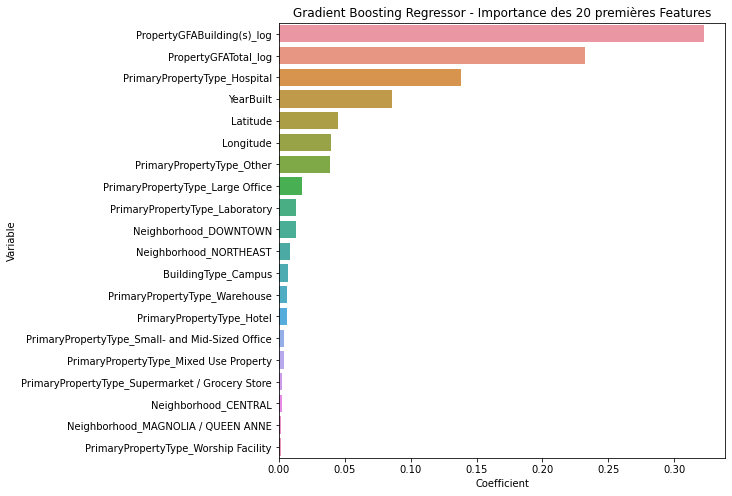

In [65]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

In [66]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'RobustScaler', results)

### Résultat du 4ème essai

In [67]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,1.111780e+07,1.724832e+07,-0.007317,0.000000
1,RidgeCV,Premières prédictions,8.808769e+06,1.380202e+07,0.367648,0.359687
2,RFR,Premières prédictions,7.220680e+06,9.844333e+06,0.575102,0.674254
3,Gradient Boosting,Premières prédictions,7.439378e+06,8.866175e+06,0.548974,0.735772
4,RidgeCV,Passage au log de la variable cible,1.251702e+00,1.628812e+00,0.234730,0.242211
5,RFR,Passage au log de la variable cible,1.072386e+00,1.450636e+00,0.438286,0.398932
6,Gradient Boosting,Passage au log de la variable cible,1.069047e+00,1.409123e+00,0.441779,0.432842
7,RidgeCV,passage au log des features asymétriques,7.504394e+06,1.237706e+07,0.541056,0.485078
8,RFR,passage au log des features asymétriques,7.421355e+06,1.096717e+07,0.551157,0.595707
9,Gradient Boosting,passage au log des features asymétriques,7.248482e+06,9.863902e+06,0.571824,0.672958


# 5eme essai : optimisation du modèle
On se concentre sur l'algorithme le plus performant et on optimise les hyperparamètres et les variables choisies

In [68]:
df_5eme_essai = df.drop(['TotalGHGEmissions',
                         'TotalGHGEmissions_log',
                         'ENERGYSTARScore',
                         'Electricity_ratio',
                         'Steam_ratio', 
                         'NaturalGas_ratio',
                         'NumberofBuildings',
                         'NumberofFloors',
                         'NumberofBuildings_log',
                         'NumberofFloors_log',
                         'PropertyGFATotal_log',
                        #'PropertyGFATotal',
                         'PropertyGFAParking',
                         'PropertyGFAParking_log',
                          #'PropertyGFABuilding(s)',
                         'PropertyGFABuilding(s)_log',
                         'SiteEnergyUseWN(kBtu)_log',
                         
                        ] 
                        #+ columns_PrimaryPropertyType 
                        #+ columns_PropertyUse_ratio 
                        + columns_BuildingType
                        + columns_Neighborhood
                        , axis=1)

In [69]:
df_5eme_essai.columns

Index(['Latitude', 'Longitude', 'YearBuilt', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'SiteEnergyUseWN(kBtu)',
       'PropertyUse_ratio_Education', 'PropertyUse_ratio_Factory',
       'PropertyUse_ratio_Government services', 'PropertyUse_ratio_Health',
       'PropertyUse_ratio_Hotel/Senior Care/Housing',
       'PropertyUse_ratio_Leisure', 'PropertyUse_ratio_No Use',
       'PropertyUse_ratio_Office', 'PropertyUse_ratio_Other',
       'PropertyUse_ratio_Parking', 'PropertyUse_ratio_Retail',
       'PropertyUse_ratio_Swimming Pool',
       'PropertyUse_ratio_Technology/Science',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated 

### On sépare la variable cible et les features

In [70]:
X5= df_5eme_essai.drop(['SiteEnergyUseWN(kBtu)'], axis=1)
y5= df_5eme_essai['SiteEnergyUseWN(kBtu)']

### On sépare les données d'entrainement et de test et on standardise les données numérique

In [71]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X5, y5, test_size=0.3, random_state=123) # 30% des données dans le jeu de test

#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X_train)

X_train_std = pd.DataFrame(data=robustscaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=robustscaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Gradient Boosting Regressor

In [72]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":[None,"log2","sqrt"],
              'learning_rate': [0.05,0.1,0.2], # eta value
              'max_depth': [1,2,3],
              'min_samples_leaf': [1,2,5],
              #'subsample': [0.7,0.8,0.9,1],
              'n_estimators': [10,50,200,500,700], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state=123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 10,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [1, 2, 3],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [10, 50, 200, 500, 700]},
             scoring='r2')

In [73]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le GBR sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le GBR sont :{'learning_rate': 0.2, 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
score train : 0.9150290939172565
score test : 0.6818930790403845
rmse train : 5027844.42220082
rmse test : 6247731.719461291


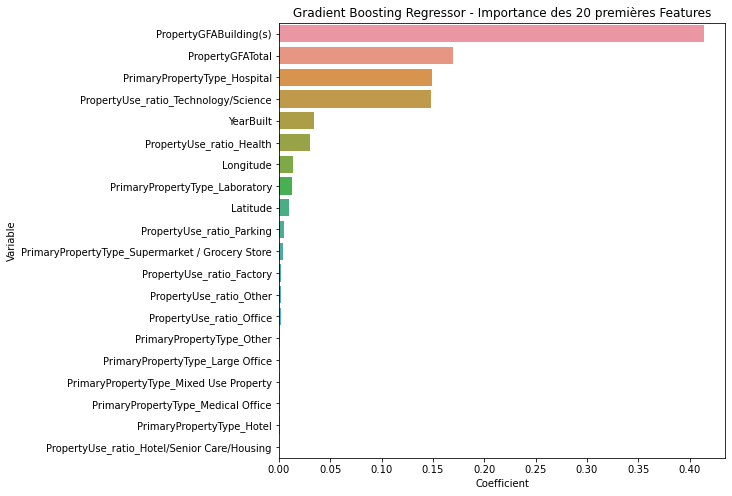

In [74]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

In [75]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting', 'optimisation du modèle', results)

### Résultat du 5ème essai

In [76]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,1.111780e+07,1.724832e+07,-0.007317,0.000000
1,RidgeCV,Premières prédictions,8.808769e+06,1.380202e+07,0.367648,0.359687
2,RFR,Premières prédictions,7.220680e+06,9.844333e+06,0.575102,0.674254
3,Gradient Boosting,Premières prédictions,7.439378e+06,8.866175e+06,0.548974,0.735772
4,RidgeCV,Passage au log de la variable cible,1.251702e+00,1.628812e+00,0.234730,0.242211
5,RFR,Passage au log de la variable cible,1.072386e+00,1.450636e+00,0.438286,0.398932
6,Gradient Boosting,Passage au log de la variable cible,1.069047e+00,1.409123e+00,0.441779,0.432842
7,RidgeCV,passage au log des features asymétriques,7.504394e+06,1.237706e+07,0.541056,0.485078
8,RFR,passage au log des features asymétriques,7.421355e+06,1.096717e+07,0.551157,0.595707
9,Gradient Boosting,passage au log des features asymétriques,7.248482e+06,9.863902e+06,0.571824,0.672958


## Verification de la performance du modèle avec un KFold cross-validation

In [77]:
df_6eme_essai = df.drop(['TotalGHGEmissions',
                         'TotalGHGEmissions_log',
                         'ENERGYSTARScore',
                         'Electricity_ratio',
                         'Steam_ratio', 
                         'NaturalGas_ratio',
                         'NumberofBuildings',
                         'NumberofFloors',
                         'NumberofBuildings_log',
                         'NumberofFloors_log',
                         'PropertyGFATotal_log',
                        #'PropertyGFATotal',
                         'PropertyGFAParking',
                         'PropertyGFAParking_log',
                          #'PropertyGFABuilding(s)',
                         'PropertyGFABuilding(s)_log',
                         'SiteEnergyUseWN(kBtu)_log',
                         
                        ] 
                        #+ columns_PrimaryPropertyType 
                        #+ columns_PropertyUse_ratio 
                        + columns_BuildingType
                        + columns_Neighborhood
                        , axis=1)

In [78]:
X6= df_6eme_essai.drop(['SiteEnergyUseWN(kBtu)'], axis=1)
y6= df_6eme_essai['SiteEnergyUseWN(kBtu)']

In [79]:
#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X6)

X6_std = pd.DataFrame(data=robustscaler.transform(X6),index=X6.index,columns=X6.columns)


In [80]:
from sklearn.model_selection import KFold, cross_val_score,cross_val_predict

parameters = {'learning_rate': 0.2, 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
model = GradientBoostingRegressor(random_state=123, **parameters)

scores = cross_val_score(model, X6_std, y6, 
                         scoring='r2',
                         cv=KFold(10), n_jobs=-1)

In [81]:
#That is, the average r2 error between the model prediction and the actual observed data
np.mean(abs(scores))

0.4868287052490346

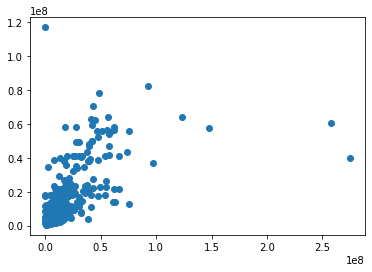

In [82]:
# Make cross validated predictions
predictions = cross_val_predict(model, X6_std, y6, cv=10)
plt.scatter(y6, predictions)

In [83]:
accuracy = r2_score(y6, predictions)
print('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: 0.4670230142880195


## Analyse de l’influence de l’EnergyStarScore sur le modèle choisi

Le modèle choisi est le modèle sans passage au log pour aucunes variables et **l'algorithme Gradient Boosting Regressor**

On va entraîner le modèle final choisi avec le nouveau dataset,
une fois avec la feature EnergyStarScore,
une fois sans cette feature 
et comparer les scores et la feature importance, afin de démontrer l’apport réel de cette feature


### On ne garde que le dataframe avec des lignes où l'Energie Star Score est présent

In [84]:
#On supprime les lignes où il y a une valeur manquante (Energy Star Score)
df_dropna_ess = df.dropna(axis =0)

### Entrainement du modèle finale sans l'Energie Star Score

In [85]:
df_sans_ess = df_dropna_ess.drop(['TotalGHGEmissions',
                         'TotalGHGEmissions_log',
                         'ENERGYSTARScore',
                         'Electricity_ratio',
                         'Steam_ratio', 
                         'NaturalGas_ratio',
                         'NumberofBuildings',
                         'NumberofFloors',
                         'NumberofBuildings_log',
                         'NumberofFloors_log',
                         'PropertyGFATotal_log',
                         'PropertyGFAParking',
                         'PropertyGFAParking_log',
                         'PropertyGFABuilding(s)_log',
                         'SiteEnergyUseWN(kBtu)_log'
                         
                        ] 
                        + columns_BuildingType
                        + columns_Neighborhood
                        , axis=1)

In [86]:
#Nous allons séparer les données en un ensemble de données X 
#et une variable cible y que nous voulons prédire.
X_sans_ess = df_sans_ess.drop(['SiteEnergyUseWN(kBtu)'], axis=1)
y_sans_ess = df_sans_ess['SiteEnergyUseWN(kBtu)']

In [87]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_sans_ess, y_sans_ess, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données 
robustscaler = RobustScaler()
robustscaler.fit(X_train)

X_train_std = pd.DataFrame(data=robustscaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=robustscaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Gradient Boosting Regressor sans L'Energy Star Score

In [88]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6, 7],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500,700,1000], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state = 123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 10,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6, 7],
                         'n_estimators': [5, 10, 15, 20, 100, 500, 700, 1000],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [89]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 20, 'subsample': 0.7}
score train : 0.8059931908570109
score test : 0.6596099787559957
rmse train : 8228819.624398584
rmse test : 6813904.15240717


In [90]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting sans ESS', "Influence de L'Energie Star Score", results)

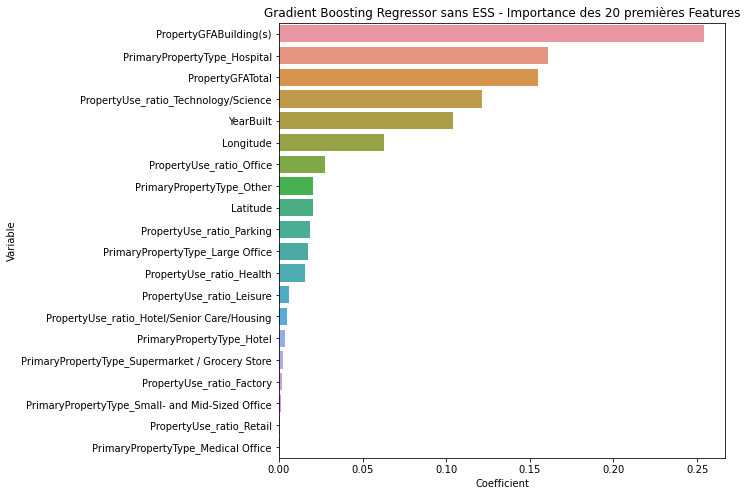

In [91]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor sans ESS - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

### Entrainement du modèle finale avec l'Energie Star Score

In [92]:
df_ess = df_dropna_ess.drop(['TotalGHGEmissions',
                         'TotalGHGEmissions_log',
                         'Electricity_ratio',
                         'Steam_ratio', 
                         'NaturalGas_ratio',
                         'NumberofBuildings',
                         'NumberofFloors',
                         'NumberofBuildings_log',
                         'NumberofFloors_log',
                         'PropertyGFATotal_log',
                         'PropertyGFAParking',
                         'PropertyGFAParking_log',
                         'PropertyGFABuilding(s)_log',
                         'SiteEnergyUseWN(kBtu)_log',
                         
                        ] 
                        + columns_BuildingType
                        + columns_Neighborhood
                        , axis=1)

In [93]:
#Nous allons séparer les données en un ensemble de données X 
#et une variable cible y que nous voulons prédire

X_ess = df_ess.drop(['SiteEnergyUseWN(kBtu)'], axis=1)
y_ess = df_ess['SiteEnergyUseWN(kBtu)']

In [94]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_ess, y_ess, test_size=0.3, random_state = 123) # 30% des données dans le jeu de test

#On standardise les données

robustscaler = RobustScaler()
robustscaler.fit(X_train)

X_train_std = pd.DataFrame(data=robustscaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_std = pd.DataFrame(data=robustscaler.transform(X_test),index=X_test.index,columns=X_test.columns)

### Gradient Boosting Regressor avec L'Energy Star Score

In [95]:
# Fixer les valeurs des hyperparamètres à tester
parameters = {"max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,0.5,1,0.5], # eta value
              'max_depth': [3,4,5],
              'min_samples_leaf': [2,4,5,6,10],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20,100,500,700,1000], #number of trees, change it to 1000 for better results
}


# Créer un regresseur XGBoost avec recherche d'hyperparamètre par validation croisée
gbr_grid = model_selection.GridSearchCV(GradientBoostingRegressor(random_state=123),
                                        param_grid = parameters,
                                        scoring = 'r2',
                                        cv = 10,
                                        n_jobs = -1)

# Optimiser ce regresseur sur le jeu d'entraînement
gbr_grid.fit(X_train_std, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 0.5],
                         'max_depth': [3, 4, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 5, 6, 10],
                         'n_estimators': [5, 10, 15, 20, 100, 500, 700, 1000],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2')

In [96]:
# Afficher le(s) hyperparamètre(s) optimaux
print("les meilleurs hyperparamètres pour le XGB sont :{}".format(gbr_grid.best_params_))

# Scores R2
print('score train :', gbr_grid.score(X_train_std, y_train))
print('score test :', gbr_grid.score(X_test_std, y_test))

# Scores RMSE
print('rmse train :', np.sqrt(mean_squared_error(gbr_grid.predict(X_train_std), y_train)))
print('rmse test :', np.sqrt(mean_squared_error(gbr_grid.predict(X_test_std), y_test)))

les meilleurs hyperparamètres pour le XGB sont :{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000, 'subsample': 0.8}
score train : 0.9999987639328072
score test : 0.7376512387021411
rmse train : 20770.650407308607
rmse test : 5982009.787752524


In [97]:
# On ajoute les scores au dataframe results
results = add_results(gbr_grid, 'Gradient Boosting avec ESS', "Influence de L'Energie Star Score", results)

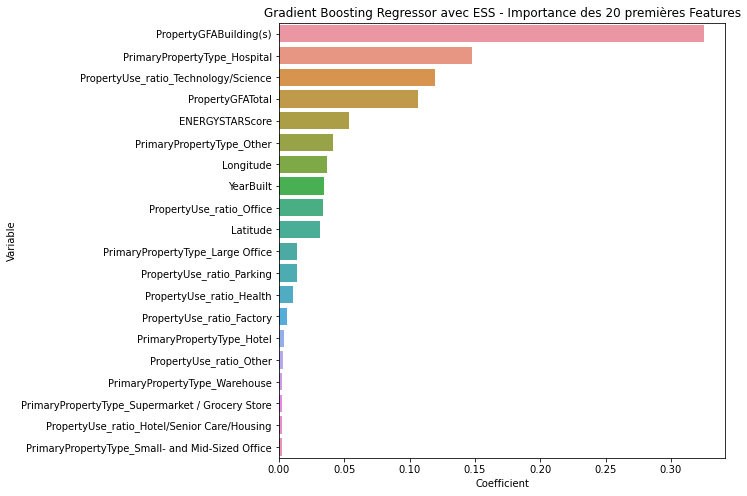

In [98]:
#On affiche les variables les plus importantes dans le modele 

coefficients = abs(gbr_grid.best_estimator_.feature_importances_)
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)


plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor avec ESS - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()

### Resultats finaux 

In [99]:
results

,Modèle,Cas,Score_RMSE_test,Score_RMSE_train,Score_r2_test,Score_r2_train
0,Dummy Regressor,Premières prédictions,1.111780e+07,1.724832e+07,-0.007317,0.000000
1,RidgeCV,Premières prédictions,8.808769e+06,1.380202e+07,0.367648,0.359687
2,RFR,Premières prédictions,7.220680e+06,9.844333e+06,0.575102,0.674254
3,Gradient Boosting,Premières prédictions,7.439378e+06,8.866175e+06,0.548974,0.735772
4,RidgeCV,Passage au log de la variable cible,1.251702e+00,1.628812e+00,0.234730,0.242211
5,RFR,Passage au log de la variable cible,1.072386e+00,1.450636e+00,0.438286,0.398932
6,Gradient Boosting,Passage au log de la variable cible,1.069047e+00,1.409123e+00,0.441779,0.432842
7,RidgeCV,passage au log des features asymétriques,7.504394e+06,1.237706e+07,0.541056,0.485078
8,RFR,passage au log des features asymétriques,7.421355e+06,1.096717e+07,0.551157,0.595707
9,Gradient Boosting,passage au log des features asymétriques,7.248482e+06,9.863902e+06,0.571824,0.672958


### Conclusion

L'energie Star Score a bien une influence sur les scores de la prediction de la variable SiteEnergyUseWN, quand on le rajoute dans le modèle les scores s'améliorent.

Il apparait comme la 5ème variable plus importante dans le modèle.